In [412]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from jre_utils.datapath import model_ready_data_paths

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [413]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [414]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"

In [415]:
start_year = 2006
eval_start_year = 2021 # eval_years = [2021]

dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}"]
df = pd.read_csv(model_ready_data_path)
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [416]:
df.columns

Index(['unit_price_wmedian_pct_chg', 'unit_price_wmedian', 'year', 'count',
       'total_traded_area', 'population', 'taxpayer_count', 'taxable_income',
       'taxable_income_per_taxpayer', 'taxable_income_growth',
       'taxable_income_per_taxpayer_growth', 'new_dwellings',
       'existing_dwellings', 'net_migration_ratio', 'new_dwellings_ratio',
       'area_code'],
      dtype='object')

In [417]:
columns = [
    metric,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

In [418]:
columns_normalized

['unit_price_wmedian_normalized',
 'count_normalized',
 'total_traded_area_normalized',
 'population_normalized',
 'taxpayer_count_normalized',
 'taxable_income_normalized',
 'taxable_income_per_taxpayer_normalized',
 'taxable_income_growth_normalized',
 'taxable_income_per_taxpayer_growth_normalized',
 'new_dwellings_normalized',
 'existing_dwellings_normalized',
 'new_dwellings_ratio_normalized',
 'net_migration_ratio_normalized']

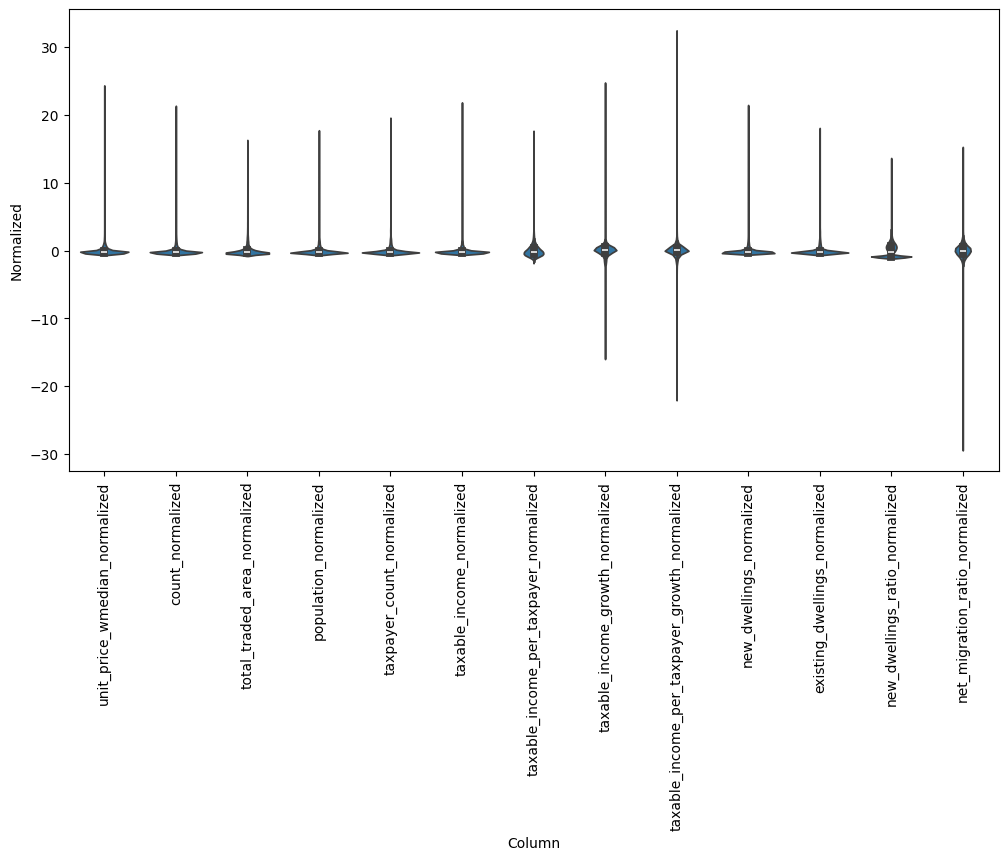

In [419]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [420]:
class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        complete_df,
        df,
        metrics=[metric_pct_chg],
        feature_columns=None,
        shift=1,
        window_length=5,
        transform=None,
    ):
        self.feature_columns = feature_columns if feature_columns is not None else df.columns
        self.complete_df = complete_df
        self.df = df
        self.transform = transform
        self.metrics = metrics
        self.shift = shift
        self.window_length = window_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        target = row[self.metrics]
        area_code, year = row["area_code"], row["year"]
        area_df = (
            self.complete_df[
                (self.complete_df["area_code"] == area_code)
                & (self.complete_df["year"] <= year - self.shift)
            ]
            .sort_values(by="year")  # sorting just to be safe
            .tail(self.window_length)
        )

        sample = {
            "window": area_df[self.feature_columns],
            "target": target,
            "area_code": area_code, 
            "year": year
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToNumpy(object):
    """Convert pandas dataframes in sample to ndarrays."""

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]
        return {"window": window.values, "target": target.values}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        window, target, mask = sample["window"], sample["target"], sample["mask"]
        return {
            "window": torch.from_numpy(window),
            "mask": torch.from_numpy(mask),
            "target": torch.from_numpy(target),
        }


class PadAndMask(object):
    """Pad all inputs to be of the same length and create a mask"""

    def __init__(self, pad_length=5):
        self.pad_length = pad_length

    def __call__(self, sample):
        window, target = sample["window"], sample["target"]

        # the first n elements of the mask are 1, the rest are 0
        mask = np.zeros(self.pad_length)
        mask[: window.shape[0]] = 1

        padded_window = np.pad(
            window, ((0, self.pad_length - window.shape[0]), (0, 0)), "constant"
        )
        return {"window": padded_window, "mask": mask, "target": target}

In [327]:
feature_columns = [metric_pct_chg] + columns_normalized
time_series_dataset = TimeSeriesDataset(df, train_df, feature_columns=feature_columns)
time_series_dataset_transformed = TimeSeriesDataset(
    df, train_df, transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()])
)

for i, sample in enumerate(time_series_dataset):
    print(i, sample["window"].shape, sample["target"].shape, sample["target"].values)
    if i == 3:
        break


for i, sample in enumerate(time_series_dataset_transformed):
    print(i, sample["window"].shape, sample["target"].shape, sample["target"])
    if i == 3:
        break

0 (0, 14) (1,) [0.06132887]
1 (1, 14) (1,) [0.07620321]
2 (2, 14) (1,) [-0.04347826]
3 (3, 14) (1,) [-0.02787398]
0 torch.Size([5, 29]) torch.Size([1]) tensor([0.0613], dtype=torch.float64)
1 torch.Size([5, 29]) torch.Size([1]) tensor([0.0762], dtype=torch.float64)
2 torch.Size([5, 29]) torch.Size([1]) tensor([-0.0435], dtype=torch.float64)
3 torch.Size([5, 29]) torch.Size([1]) tensor([-0.0279], dtype=torch.float64)


In [329]:
train_dataset = TimeSeriesDataset(
    df, train_df, feature_columns=feature_columns, transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()])
)
eval_dataset = TimeSeriesDataset(
    df, eval_df, feature_columns=feature_columns, transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()])
)


In [330]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False, num_workers=0)

In [331]:
for i, sample in enumerate(train_dataloader):
    print(i, sample["window"].shape, sample["target"].shape)
    if i == 0:
        break

0 torch.Size([64, 5, 14]) torch.Size([64, 1])


### Building the Transformer Model

In [332]:
import math

from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer


In [385]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TimeSeriesTransformerModel(nn.Module):
    def __init__(
            self,
            n_features: int,
            d_model: int,
            nhead: int, 
            d_hid: int, 
            nlayers: int,
            dropout: float = 0.1,
            emb_dropout: float = 0.1,
            device: str = "cpu",
    ):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(n_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, nlayers)
        self.linear = nn.Linear(d_model, 1)
        self.device = device

    def init_weights(self) -> None:
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, window: Tensor, mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[batch_size, seq_len, n_features]`` -> ``[seq_len, batch_size, n_features]`` 
            src_mask: Tensor, shape ``[batch_size, seq_len]``
        
        Returns:
            output: Tensor, shape ``[batch_size, 1]``
        """
        window = window.permute(1, 0, 2)
        window = self.embedding(window)
        window = self.pos_encoder(window)
        output_layer = self.transformer_encoder(window, src_key_padding_mask=mask)
        pooled_output = torch.mean(output_layer, dim=0)
        final_output = self.linear(pooled_output)
        return final_output

In [386]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [401]:
n_features = len(feature_columns)
d_model = 128
d_hid = 128
nlayers = 2
nhead = 2
dropout = 0.1
emb_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    emb_dropout=emb_dropout,
    device=device,
)

In [402]:
data_iter = iter(train_dataloader)
batch = next(data_iter)
print(batch['window'].shape, batch['mask'].shape, batch['target'].shape)


torch.Size([64, 5, 14]) torch.Size([64, 5]) torch.Size([64, 1])


In [403]:
window = batch['window'].to(torch.float32).to(device)
mask = batch['mask'].to(torch.float32).to(device)
target = batch['target'].to(torch.float32).to(device)
model = model.to(device)

In [404]:
output = model(window, mask)
output.shape


torch.Size([64, 1])

In [405]:
learning_rate = 1e-4 # 3e-4
num_epochs = 50

In [406]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=learning_rate)
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

print(num_training_steps)

14400


In [409]:
# from torch.nn import MSELoss
# from torcheval.metrics import R2Score

# mse_loss = MSELoss()

# progress_bar = tqdm(range(num_training_steps))

# train_losses, train_r2_scores, eval_losses, eval_r2_scores = [], [], [], []

# phases = ["train", "eval"]

# for epoch in range(num_epochs):
#     for phase in phases:
#         running_loss = 0.0
#         r2_score = R2Score(device=device)

#         if phase == "train":
#             model.train()
#             dataloader, losses, r2_scores = train_dataloader, train_losses, train_r2_scores
#         else:
#             model.eval()
#             dataloader, losses, r2_scores = eval_dataloader, eval_losses, eval_r2_scores

#         for batch in dataloader:
#             window = batch["window"].to(torch.float32).to(device)
#             mask = batch["mask"].to(torch.float32).to(device)
#             target = batch["target"].to(torch.float32).to(device)

#             outputs = model(window, mask)
#             loss = mse_loss(outputs, target)

#             if phase == "train":
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 lr_scheduler.step()
#                 progress_bar.update(1)

#             running_loss += loss.item() * len(batch)
#             r2_score.update(outputs, target)

#         losses.append(running_loss / len(dataloader))
#         r2_scores.append(r2_score.compute().item())

# progress_bar.close()

100%|██████████| 14400/14400 [21:11<00:00, 11.33it/s] 


In [394]:
# The results above are almost too good to be true. What feels extra sus is that the losses and r2_scores for eval and train move in tandem
# I will try a different training method

from torch.nn import MSELoss
from torcheval.metrics import R2Score
from transformers import AdamW, get_scheduler

mse_loss = MSELoss()

num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

def train(model, progress_bar):
    model.train()
    
    running_loss = 0.0
    r2_score = R2Score(device=device)

    for batch in train_dataloader:
        window = batch["window"].to(torch.float32).to(device)
        mask = batch["mask"].to(torch.float32).to(device)
        target = batch["target"].to(torch.float32).to(device)

        outputs = model(window, mask)
        loss = mse_loss(outputs, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item() * len(batch)
        r2_score.update(outputs, target)
        progress_bar.update(1)

    return running_loss / len(train_dataloader), r2_score.compute().item()
    
def evaluate(model):
    model.eval()
    
    running_loss = 0.0
    r2_score = R2Score(device=device)

    with torch.no_grad():
        for batch in eval_dataloader:
            window = batch["window"].to(torch.float32).to(device)
            mask = batch["mask"].to(torch.float32).to(device)
            target = batch["target"].to(torch.float32).to(device)

            outputs = model(window, mask)
            loss = mse_loss(outputs, target) 

            running_loss += loss.item() * len(batch)
            r2_score.update(outputs, target)

    return running_loss / len(eval_dataloader), r2_score.compute().item()

In [395]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [396]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(model, progress_bar)
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

progress_bar.close()

100%|██████████| 14400/14400 [25:59<00:00,  9.23it/s] 


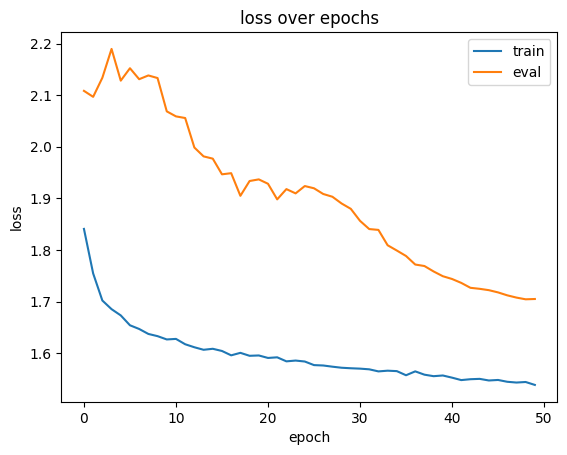

In [410]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

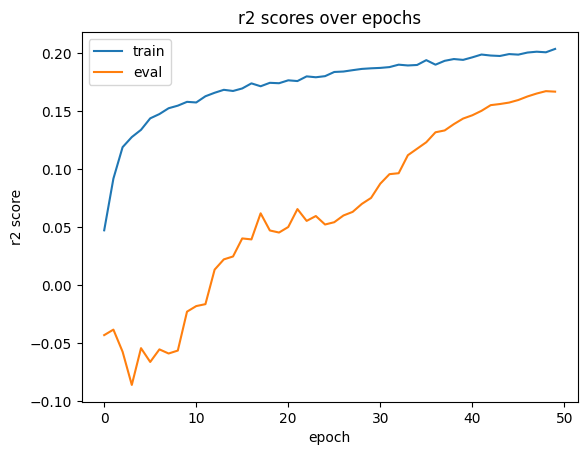

In [411]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [399]:
# untrained model
loss, epoch_r2_score = evaluate(model)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 1.7759
Eval R2: 0.1341


In [ ]:
# Needs more data!!!

In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

#### The High Bias Problem (Fixed):

Right now, it seems to be that the model is facing a problem with high bias. The loss mins out at around 0.4
This is a problem, because the reason I built this model was because I thought it could outperform the XGBoost model.
But as it stands, the XGboost brings down loss to as low as 0.05.
Now, it is overfitting considerably with Train R2 being 0.3979 and Test R2 being 0.2376
But it is pretty surprising that the model is not able to fit harder.

The solutions suggested by Andrew Ng are:
1. Bigger Network (Increase number of hidden units, attention heads, and layers)
2. Train for longer (more number of epoch)
   1. I'm doing this, but weirdly enough, it ends up just slowing the model instead of progressing this further
3. Use a different architechture
   1. Maybe I'm being stubborn, but the advent of transformer models have changed machine learning permanently. So I would like to continue the use of this architecture

### The High Variance Problem

The model is overfitting right now

In [ ]:

# How do I make the model better?
# Model is currently underfitting. Make it overfit first.

# Basic
# Hyperparameter Tuning
#   1. Learning rate.
#   2. No. of hidden units.
#   3. No. of layers.
# Alternative Cost Function
#   1. Weighted MSE loss - Weighted on count

# Advanced
# Pretrain on the Time Series Datasets
